# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sympy as sym
import statsmodels.api as sm
import typing as tp


Bad key "text.kerning_factor" on line 4 in
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
from state_space.data_reader import (
    load_monthly_and_annual_ff_factors, 
    compute_monthly_returns
)

In [4]:
from state_space import (
    SymbolicStateSpaceModelViaMaximumLikelihood, 
    LambdaParameterTransformation, 
    RectangularParameterTransformation, 
    linearize_vector_valued_state_function
)

# Load Data

In [5]:
data_directory_name = 'data'
ford_data_filename = os.path.join(data_directory_name, 'F_monthly.csv')
gspc_data_filename = os.path.join(data_directory_name, '^GSPC_monthly.csv')
ff_data_filename = os.path.join(data_directory_name, 'F-F_Research_Data_Factors_monthly.CSV')

In [6]:
ford_prices = pd.read_csv(ford_data_filename).set_index('Date')
gspc_prices = pd.read_csv(gspc_data_filename).set_index('Date')

Load Fama-French factors

In [7]:
ff_monthly, ff_annual = load_monthly_and_annual_ff_factors(ff_data_filename)

# Prepare Data

Compute Ford returns

In [8]:
ford_returns = compute_monthly_returns(ford_prices, name='ford')

Compute S&P 500 index returns

In [9]:
gspc_returns = compute_monthly_returns(gspc_prices, name='gspc')

Compute excess returns on both

In [10]:
gspc_excess_returns = gspc_returns - ff_monthly['RF']
ford_excess_returns = ford_returns - ff_monthly['RF']

Put Ford and S&P 500 returns in a single dataframe

In [11]:
joint_returns = pd.DataFrame({'ford': ford_returns, 'gspc': gspc_returns, 'rf': ff_monthly['RF']}).dropna()

In [12]:
joint_excess_returns = pd.DataFrame({'ford': ford_excess_returns, 'gspc': gspc_excess_returns}).dropna()

Restrict the time horizon from 1990 to 2004

In [13]:
restricted_joint_excess_returns = joint_excess_returns.query('Date >= 1990 and Date < 2004')

# Conditional Factor Model and State-Space Representation

## Stochastic Process Model

Consider a univariate linear factor model with time-varying coefficients, where the factor is the return on an equity index. This model can be written as

$r_t = \alpha_t + \beta_t r_{M, t} + e_t$

$\alpha_{t+1} = \alpha_t + \eta_t$

$\beta_{t+1} = \beta_t + \epsilon_t$

where $r_t$ is the excess return of the stock over period $t$ and $r_{M, t}$ is the excess return of the market over period $t$. The innovations $e$, $\eta$, and $\epsilon$ are both serially and mutually independent and distributed as follows:

$e_t \sim N(0, \sigma^2_e)$

$\eta_t \sim N(0, \sigma^2_{\eta})$

$\epsilon_t \sim N(0, \sigma^2_{\epsilon})$

## State Space Representation

This model can be represented in statespace form as:

$s_t = \begin{pmatrix} \alpha_t \\ \beta_t \end{pmatrix}$ (state), 

$y_t = r_t$ (observation)

$s_{t+1} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \cdot s_t + \begin{pmatrix} \eta_t \\ \epsilon_t \end{pmatrix}$

$y_t = \begin{pmatrix} 1 & r_{M, t} \end{pmatrix} \cdot s_t + e_t $

We can further combine the processes

$\begin{pmatrix} s_{t+1} \\ y_t \end{pmatrix} = \delta_t + \Phi_t s_t + u_t$, 

where

$\delta_t = \begin{pmatrix} 0 \\ 0 \\ 0 \end{pmatrix}$, $\Phi_t = \begin{pmatrix} 1 & 0 \\ 0 & 1 \\ 1 & r_{M, t} \end{pmatrix}$, $u_t = \begin{pmatrix} \eta_t \\ \epsilon_t \\ e_t \end{pmatrix}$

## Representation in SymPy

Initialize symbols

In [14]:
sigma_e, sigma_eta, sigma_epsilon, alpha, beta, r, r_M = \
    sym.symbols('sigma_e, sigma_eta, sigma_epsilon, alpha, beta, r, r_M')

Model parameters to be estimated

In [15]:
parameter_symbols = (sigma_e, sigma_eta, sigma_epsilon)

Define the state vector

In [16]:
state_vector_symbols = (alpha, beta)

Define the vector of observations

In [17]:
observation_vector_symbols = (r, )

Define mapping between data symbols and Pandas series/NumPy arrays

In [18]:
data_symbol_to_data_map = {r: restricted_joint_excess_returns['ford'], 
                           r_M: restricted_joint_excess_returns['gspc']}

Set starting values for the maximum likelihood estimation via numerical optimization

In [19]:
ford_return_std = np.std(restricted_joint_excess_returns['ford'])
parameter_symbols_to_start_parameters_map = {sigma_e: ford_return_std, 
                                             sigma_eta: ford_return_std,
                                             sigma_epsilon: ford_return_std}

Define transformation functions to ensure that the variance parameters remain positive (the optimizer is unconstrained)

Option A: Using a vectorized transformation function (the same for all parameters)

In [20]:
parameter_transformation = \
    LambdaParameterTransformation(transform_function=lambda x: x**2, 
                                  untransform_function=lambda x: x**0.5)

Option B: Using individual lower and upper bounds

In [21]:
# parameter_transformation = \
#     RectangularParameterTransformation(parameter_symbols=parameter_symbols, 
#                                        parameter_symbol_to_bounds_map={sigma_e: (0, np.inf), 
#                                                                        sigma_eta: (0, np.inf), 
#                                                                        sigma_epsilon: (0, np.inf)})

Construct transition matrix in SymPy

In [22]:
transition_matrix = sym.eye(2)
transition_matrix

Matrix([
[1, 0],
[0, 1]])

Construct design matrix in SymPy

In [23]:
design_matrix = sym.Matrix([[1, r_M]])
design_matrix

Matrix([[1, r_M]])

We can alternatively express the transition and observation functions as a vector valued functions of state variables and linearize the function. For non-linear transition and observation functions this leads in the extended Kalman filter (EKF).

In [24]:
f = sym.Matrix([[alpha], [beta]])
g = sym.Matrix([[alpha + beta * r_M]])

In [25]:
state_intercept_vector_ekf, transition_matrix_ekf = \
    linearize_vector_valued_state_function(f, state_vector_symbols=state_vector_symbols)
print(state_intercept_vector_ekf)
print(transition_matrix_ekf)

Matrix([[0], [0]])
Matrix([[1, 0], [0, 1]])


In [26]:
observation_intercept_vector_ekf, design_matrix_ekf = \
    linearize_vector_valued_state_function(g, state_vector_symbols=state_vector_symbols)
print(observation_intercept_vector_ekf)
print(design_matrix_ekf)

Matrix([[0]])
Matrix([[1, r_M]])


Construct selection matrix in SymPy

In [27]:
selection_matrix = sym.eye(2)
selection_matrix

Matrix([
[1, 0],
[0, 1]])

Construct state covariance matrix matrix in SymPy

In [28]:
state_covariance_matrix = sym.diagonalize_vector(sym.Matrix([sigma_eta**2, sigma_epsilon**2]))
state_covariance_matrix

Matrix([
[sigma_eta**2,                0],
[           0, sigma_epsilon**2]])

Construct observation covariance matrix matrix in SymPy

In [29]:
observation_covariance_matrix = sym.Matrix([[sigma_e**2]])

Compile numeric state space representation for MLE from the symbolic definition

In [30]:
conditional_factor_model = \
    SymbolicStateSpaceModelViaMaximumLikelihood(parameter_symbols=parameter_symbols, 
                                                state_vector_symbols=state_vector_symbols, 
                                                observation_vector_symbols=observation_vector_symbols, 
                                                data_symbol_to_data_map=data_symbol_to_data_map, 
                                                parameter_symbols_to_start_parameters_map=parameter_symbols_to_start_parameters_map, 
                                                parameter_transformation=parameter_transformation, 
                                                design_matrix=design_matrix, 
                                                observation_covariance_matrix=observation_covariance_matrix, 
                                                selection_matrix=selection_matrix, 
                                                state_covariance_matrix=state_covariance_matrix, 
                                                transition_matrix=transition_matrix)

# Estimation

Fit the model using MLE (recall that we are fitting the three variance parameters)

In [31]:
res = conditional_factor_model.fit(disp=False)

## Estimates

In [32]:
print(res.summary())

                                        Statespace Model Results                                       
Dep. Variable:                                               y   No. Observations:                  168
Model:             SymbolicStateSpaceModelViaMaximumLikelihood   Log Likelihood                 148.798
Date:                                         Wed, 14 Apr 2021   AIC                           -291.596
Time:                                                 16:44:16   BIC                           -282.260
Sample:                                                      0   HQIC                          -287.806
                                                         - 168                                         
Covariance Type:                                           opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sigm

## Filtered and Smoothed State

Filtered $\alpha$

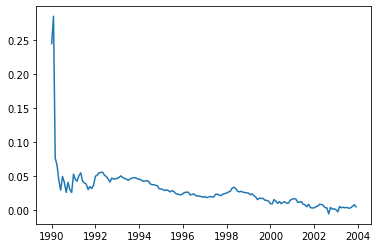

In [33]:
plt.plot(restricted_joint_excess_returns.index, res.filtered_state[0, :]);

Smoothed $\alpha$

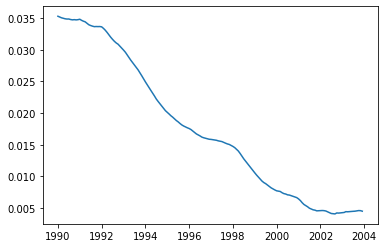

In [34]:
plt.plot(restricted_joint_excess_returns.index, res.smoothed_state[0, :]);

Filtered $\beta$

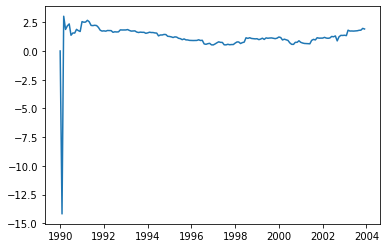

In [35]:
plt.plot(restricted_joint_excess_returns.index, res.filtered_state[1, :]);

Smoothed $\beta$

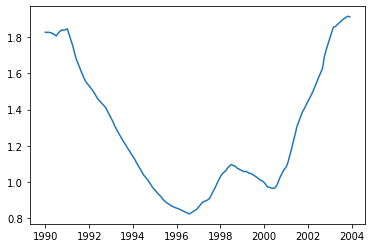

In [36]:
plt.plot(restricted_joint_excess_returns.index, res.smoothed_state[1, :]);